## 1. Download Precipitation and Isotope NEON data

In [ ]:
# Load rpy2 so R scripts can run within jupyter notebook - run this one time
%load_ext rpy2.ipython

In [ ]:
%%R 
# This rpy2 'Rmagic' command allows to run the entire cell block as R code

# Install R packages - run this one time
install.packages("neonUtilities")
install.packages('openxlsx')


In [ ]:
%%R

# Load required libraries - run this every time
library(neonUtilities)
library(openxlsx)

# creating a list of site names: this will iterate through all sites, or can be adapted to only download sites of interest
siteNames <- c("DELA", "LENO", "TALL", "BARR", "BONA", "HEAL", "TOOL", "SRER", "SJER", "CPER", "NIWO", "RMNP",
             "STER", "OSBS", "JERC", "PUUM", "KONZ", "UKFS", "SERC", "HARV", "UNDE", "BART", "NOGP", "WOOD", "OAES",
              "GUAN", "GRSM", "ORNL", "CLBJ", "MOAB", "ONAQ", "BLAN", "MLBS", "SCBI", "WREF", "STEI", "YELL")

for (val in siteNames) {
    siteName <- val
    
    # download isotope data
    IsoData <- loadByProduct(dpID="DP1.00038.001", site=siteName)
    list2env(IsoData, .GlobalEnv)
    destination <- paste("IsoData/", siteName, "IsoData.xlsx", sep="") # moves into IsoData folder and creates file name
    write.xlsx(wdi_isoPerSample, destination, row.names=F)
    
    # download precip data - primary data if available, secondary data if not
    PrecipData <- loadByProduct(dpID="DP1.00006.001", site=siteName)
    list2env(PrecipData, .GlobalEnv)
    destination <- paste("PrecipData/", siteName, "PrecipData.xlsx", sep="") # moves into PrecipData folder and creates file name
    if (exists("PRIPRE_30min")) {
        write.xlsx(PRIPRE_30min, destination, row.names=F)
    } else {
        write.xlsx(SECPRE_30min, destination, row.names=F)
    }
}

## 2. Generate a downscaled daily data product at each NEON site

In [1]:
## Python Import Statements
import os
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt

ROOTDIR = os.getcwd() # Home directory
CODEDIR = ROOTDIR + '/CODE/' # Code directory
DATADIR = ROOTDIR + '/DATA/' # Data directory

os.chdir(CODEDIR) # Change directory
import changeTimes
import getRunningMean
import conditional_copula_ts
import iso_sine_signal
import calcSiteStats

os.chdir(ROOTDIR) # Change directory

In [2]:
# User defined variables
sitenames = ["ONAQ"]
ensemble_size = 10

In [3]:
## This iterates through all the sites in 'sitenames'
for s in np.arange(len(sitenames)):
    # 30min Precipitation Data
    df_P30 = pd.read_excel(DATADIR+'PrecipData/'+str(sitenames[s])+'PrecipData.xlsx',index=False)
    df_P30 = changeTimes.change_Pdata(df_P30)
    
    # Sum to Daily Precipitation Amounts
    # checks for primary precip data
    if 'priPrecipBulk' in df_P30:
        df_P30b = df_P30.set_index('DateTime')
        precip_daily = df_P30b['priPrecipBulk'].resample('D').sum() # sum total daily P
        frac_year = df_P30b['FracYear'].resample('D').mean() # average daily FracYear (min or max better?)

        daily_P = pd.DataFrame({'Total P':precip_daily,'FracYear':frac_year})
        daily_P['Total P'].replace(0, np.nan, inplace=True)


        # Biweekly Stable Water Isotope Data
        df_iso = pd.read_excel(DATADIR+'IsoData/'+str(sitenames[s])+'IsoData.xlsx',index=False)
        df_iso = changeTimes.change_ISOdata(df_iso)



        # Create Biweekly Precipitation Amount Timeseries to Correspond to Recorded Isotope Values
        df_iso['setDate'] = pd.to_datetime(df_iso['setDate'])  
        df_iso['collectDate'] = pd.to_datetime(df_iso['collectDate']) 

        P14 = []
        for i in np.arange(len(df_iso['setDate'])):
            subset = ((df_P30['DateTime'] > df_iso['setDate'].iloc[i]) 
                    & (df_P30['DateTime'] <= df_iso['collectDate'].iloc[i]))

            df_sub = df_P30.loc[subset]
            P14.append(np.nansum(df_sub['priPrecipBulk'].values))

        df_iso['Total P'] = P14
        del P14, i, subset
    
    # uses secondary precip data
    else:
        df_P30b = df_P30.set_index('DateTime')
        precip_daily = df_P30b['secPrecipBulk'].resample('D').sum() # sum total daily P
        frac_year = df_P30b['FracYear'].resample('D').mean() # average daily FracYear (min or max better?)

        daily_P = pd.DataFrame({'Total P':precip_daily,'FracYear':frac_year})
        daily_P['Total P'].replace(0, np.nan, inplace=True)


        # Biweekly Stable Water Isotope Data
        df_iso = pd.read_excel(DATADIR+'IsoData/'+str(sitenames[s])+'IsoData.xlsx',index=False)
        df_iso = changeTimes.change_ISOdata(df_iso)



        # Create Biweekly Precipitation Amount Timeseries to Correspond to Recorded Isotope Values
        df_iso['setDate'] = pd.to_datetime(df_iso['setDate'])  
        df_iso['collectDate'] = pd.to_datetime(df_iso['collectDate']) 

        P14 = []
        for i in np.arange(len(df_iso['setDate'])):
            subset = ((df_P30['DateTime'] > df_iso['setDate'].iloc[i]) 
                    & (df_P30['DateTime'] <= df_iso['collectDate'].iloc[i]))

            df_sub = df_P30.loc[subset]
            P14.append(np.nansum(df_sub['secPrecipBulk'].values))

        df_iso['Total P'] = P14
        del P14, i, subset
    
    
    '''
    Step 1 - Remove seasonal time series component (Section 2.b.1)
    '''
    
    # Define Sine Wave Functions
    df_iso = df_iso.sort_values('DateTime')
    df_iso = df_iso.dropna(subset=['Total P'])
    tsX = df_iso['FracYear'].values 
    tsP = df_iso['Total P'].values
    tsO = df_iso['d18OWater'].values
    tsH = df_iso['d2HWater'].values   

    dayslist = []
    for dt in np.arange(len(df_iso['DateTime'])):
        dayslist.append((df_iso['DateTime'].iloc[dt] - df_iso['DateTime'].iloc[0]).days)
    dayslist = np.array(dayslist)

    # lambda is precipitation frequency (see Eq. 4)
    p_events = df_iso[df_iso['Total P'].notna()]
    lamda = len(p_events['Total P'])/((daily_P.index.max() - daily_P.index.min()).days) 

    params1, params2 = iso_sine_signal.sine_params(sitenames[s],14,tsX,tsP,tsH,tsO) # 14 = biweekly sample, sample frequency
    tsY_sine_wave = iso_sine_signal.sine_func(tsX, params1[0],params1[1],params1[2]) # solve for amplitude, phase, offset
    adj_2H = np.array((tsH - tsY_sine_wave))    # remove seasonality from time series                       

    tsY_sine_wave = iso_sine_signal.sine_func(tsX, params2[0],params2[1],params2[2])     
    adj_18O = np.array((tsO - tsY_sine_wave))  
    
    # Get biweekly site stats of stochastic component
    biweekly_stats = np.array([[np.mean(tsP), np.mean(adj_2H), np.mean(adj_18O)],
                     [np.std(tsP), np.std(adj_2H), np.std(adj_18O)],
                     [sp.stats.pearsonr(tsP,adj_2H)[0], sp.stats.pearsonr(tsP,adj_18O)[0], sp.stats.pearsonr(adj_2H,adj_18O)[0]]])

    
    '''
    Step 2 - Predict daily statistics from biweekly time series (Section 2.b.2) Now we will need to aggregate the 
    stochastic biweekly time series - i.e. calculated weighed running means at biweekly (14-day), 28-day, 42-day, 
    56-day and 84-day intervals    
    '''

    # function defining calculated statistics on time series
    site_stats = [[sitenames[s], 14, lamda,
                   biweekly_stats[0,0], biweekly_stats[0,1], biweekly_stats[0,2],
                   biweekly_stats[1,0], biweekly_stats[1,1], biweekly_stats[1,2],
                   biweekly_stats[2,0], biweekly_stats[2,1], biweekly_stats[2,2]]]
    site_stats_check = len(site_stats)

    for n in np.arange(28,85,14):
        xday_Hb, xday_Pb, xday_Xb, days = getRunningMean.main(np.array(dayslist),np.array(tsH),np.array(tsP),tsX,n)
        xday_Ob, xday_Pb, xday_Xb, days = getRunningMean.main(np.array(dayslist),np.array(tsO),np.array(tsP),tsX,n)  

        xday_Xb = np.array(xday_Xb)
        xday_Pb = np.array(xday_Pb)
        xday_Hb = np.array(xday_Hb)
        xday_Ob = np.array(xday_Ob)   

        params1a, params2a = iso_sine_signal.sine_params(sitenames[s],n,xday_Xb,xday_Pb,xday_Hb,xday_Ob)

        tsY_sine_wave = iso_sine_signal.sine_func(xday_Xb, params1a[0],params1a[1],params1a[2])
        adj_2Hb = np.array((xday_Hb - tsY_sine_wave))                           

        tsY_sine_wave = iso_sine_signal.sine_func(xday_Xb, params2a[0],params2a[1],params2a[2])     
        adj_18Ob = np.array((xday_Ob - tsY_sine_wave))
        
        if len(xday_Pb)>2 and len(adj_2Hb)>2 and len(adj_18Ob)>2:
            calcSiteStats.main(site_stats,sitenames[s],lamda,n,xday_Pb,adj_2Hb,adj_18Ob)
            
    if len(site_stats)==site_stats_check:
        print("Site {} does not contain sufficient data.".format(sitenames[s]))
        
    else:
        ### the stats are labeled with 'B' here because they are of the stochastic component - not the original time series
        Site_Stats = pd.DataFrame(site_stats, columns = ['site','agglev','lambda','PmuB','HmuB','OmuB','PsigB',
                                                         'HsigB','OsigB','PHpB','POpB','HOpB'])
    
        ### Now we apply equation 4
        Hi = [] ; Oi = [] # estimated 1-day parameters
        H_a = [] ; O_a = [] # a term

        xaxis = np.array(Site_Stats['agglev'].values)
        yaxis1 = np.array(Site_Stats['HsigB'].values)
        yaxis2 = np.array(Site_Stats['OsigB'].values)

        def eq4(x,a,b):
            return b/(x*lamda)**a

        bounds = [[0.25,yaxis1[0]],[0.5,np.inf]]
        p1,p2 = optimize.curve_fit(eq4, xaxis, yaxis1, p0 = [0.3,yaxis1[0]], bounds=bounds)

        Hi.append(float(p1[1]))
        H_a.append(p1[0])

        bounds = [[0.2,yaxis2[0]],[0.5,np.inf]]
        p1,p2 = optimize.curve_fit(eq4, xaxis, yaxis2,  p0 = [0.3,yaxis2[0]], bounds=bounds)

        Oi.append(float(p1[1]))
        O_a.append(p1[0])
    
        
        '''
        Step 3 - Generate daily time series with estimated statistcs (Section 2.b.2)
        Step 4 - Add in seasonal time series component (Section 2.b.2)
        '''
    
        H_scale = np.sort(np.array(adj_2H) * Hi / Site_Stats['HsigB'].iloc[0])
        O_scale = np.sort(np.array(adj_18O) * Oi / Site_Stats['OsigB'].iloc[0])

        copula_stats = np.matrix([[0, 0, 0], [np.std(tsP), Hi, Oi],
                                    [Site_Stats['PHpB'].iloc[0], Site_Stats['POpB'].iloc[0],
                                    Site_Stats['HOpB'].iloc[0]]])    

        for num in np.arange(1,ensemble_size+1):
            new_ts = conditional_copula_ts.main(daily_P['Total P'],copula_stats,H_scale,O_scale)
            y = np.array([np.array(xi) for xi in new_ts])   

            # Add back in n-day sine function here:
            tsH_daily = y[:,0] + iso_sine_signal.sine_func(daily_P['FracYear'], params1[0],params1[1],params1[2])    
            tsO_daily = y[:,1] + iso_sine_signal.sine_func(daily_P['FracYear'], params2[0],params2[1],params2[2])
        
            columnA = 'd2H_'+str(num)
            columnB = 'd18O_'+str(num)
            daily_P[columnA] = tsH_daily
            daily_P[columnB] = tsO_daily 

        daily_P.to_csv(ROOTDIR+'/OUTPUT/'+sitenames[s]+'_daily_timeseries.csv')


## 3. visualize output - i.e. time series plots and dual isotope plots

In [30]:
OUTPUTDIR = ROOTDIR + '/OUTPUT/' # Output directory
os.chdir(OUTPUTDIR) # Change directory

# User input
sitename = "ONAQ"
start_date = '01-01-2019'
end_date = '12-31-2019'

# import data based on selected dates
df_timeseries = pd.read_csv(str(sitename)+'_daily_timeseries.csv')
df_timeseries['DateTime'] = pd.to_datetime(df_timeseries['DateTime'])
mask = (df_timeseries['DateTime'] >= start_date) & (df_timeseries['DateTime'] <= end_date)
df_timeseries = df_timeseries.loc[mask]

# assigning variables
t = df_timeseries.index
P = df_timeseries['Total P']
d2H = df_timeseries['d2H_1']
d18O = df_timeseries['d18O_1']

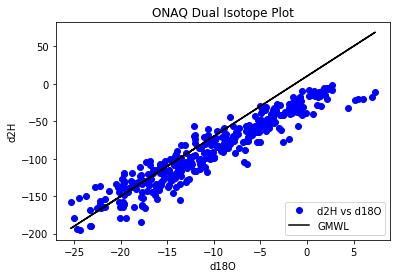

In [5]:
# creating a dual isotope plot

# define GMWL
GMWL = 8*d18O + 10

# create plot
plt.plot(d18O, d2H, 'o', color='blue', label="d2H vs d18O")
plt.plot(d18O, GMWL, color='black', label="GMWL")
plt.title(str(sitename)+" Dual Isotope Plot")
plt.xlabel("d18O")
plt.ylabel("d2H")
plt.legend(loc="lower right")

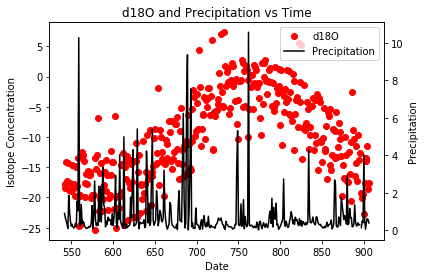

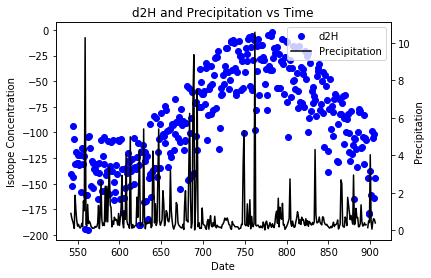

In [31]:
# creating an isotope and precipitation vs time plot

# d18O plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(t, d18O, 'o', color='red', label='d18O')
ax2.plot(t, P, color='black', label='Precipitation')

ax1.set_title('d18O and Precipitation vs Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Isotope Concentration')
ax2.set_ylabel('Precipitation')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

# d2H plot
fig, ax3 = plt.subplots()
ax4 = ax3.twinx()

ax3.plot(t, d2H, 'o', color='blue', label='d2H')
ax4.plot(t, P, color='black', label='Precipitation')

ax3.set_title('d2H and Precipitation vs Time')
ax3.set_xlabel('Date')
ax3.set_ylabel('Isotope Concentration')
ax4.set_ylabel('Precipitation')

lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
ax4.legend(lines3 + lines4, labels3 + labels4, loc=0)

## 4. Sort data to confirm statistics

In [7]:
# Site list
sitenames = ["ONAQ"]
daily_hat = []

## This iterates through all the sites in 'sitenames'
for s in np.arange(len(sitenames)):
    # 30min Precipitation Data
    df_P30 = pd.read_excel(DATADIR+'PrecipData/'+str(sitenames[s])+'PrecipData.xlsx',index=False)
    df_P30 = changeTimes.change_Pdata(df_P30)
    
    # Sum to Daily Precipitation Amounts
    # checks for primary precip data
    if 'priPrecipBulk' in df_P30:
        df_P30b = df_P30.set_index('DateTime')
        precip_daily = df_P30b['priPrecipBulk'].resample('D').sum() # sum total daily P
        frac_year = df_P30b['FracYear'].resample('D').mean() # average daily FracYear (min or max better?)

        daily_P = pd.DataFrame({'Total P':precip_daily,'FracYear':frac_year})
        daily_P['Total P'].replace(0, np.nan, inplace=True)


        # Biweekly Stable Water Isotope Data
        df_iso = pd.read_excel(DATADIR+'IsoData/'+str(sitenames[s])+'IsoData.xlsx',index=False)
        df_iso = changeTimes.change_ISOdata(df_iso)


        # Create Biweekly Precipitation Amount Timeseries to Correspond to Recorded Isotope Values
        df_iso['setDate'] = pd.to_datetime(df_iso['setDate'])  
        df_iso['collectDate'] = pd.to_datetime(df_iso['collectDate']) 

        P14 = []
        for i in np.arange(len(df_iso['setDate'])):
            subset = ((df_P30['DateTime'] > df_iso['setDate'].iloc[i]) 
                    & (df_P30['DateTime'] <= df_iso['collectDate'].iloc[i]))

            df_sub = df_P30.loc[subset]
            P14.append(np.nansum(df_sub['priPrecipBulk'].values))

        df_iso['Total P'] = P14
        del P14, i, subset
    
    # uses secondary precip data
    else:
        df_P30b = df_P30.set_index('DateTime')
        precip_daily = df_P30b['secPrecipBulk'].resample('D').sum() # sum total daily P
        frac_year = df_P30b['FracYear'].resample('D').mean() # average daily FracYear (min or max better?)

        daily_P = pd.DataFrame({'Total P':precip_daily,'FracYear':frac_year})
        daily_P['Total P'].replace(0, np.nan, inplace=True)


        # Biweekly Stable Water Isotope Data
        df_iso = pd.read_excel(DATADIR+'IsoData/'+str(sitenames[s])+'IsoData.xlsx',index=False)
        df_iso = changeTimes.change_ISOdata(df_iso)


        # Create Biweekly Precipitation Amount Timeseries to Correspond to Recorded Isotope Values
        df_iso['setDate'] = pd.to_datetime(df_iso['setDate'])  
        df_iso['collectDate'] = pd.to_datetime(df_iso['collectDate']) 

        P14 = []
        for i in np.arange(len(df_iso['setDate'])):
            subset = ((df_P30['DateTime'] > df_iso['setDate'].iloc[i]) 
                    & (df_P30['DateTime'] <= df_iso['collectDate'].iloc[i]))

            df_sub = df_P30.loc[subset]
            P14.append(np.nansum(df_sub['secPrecipBulk'].values))

        df_iso['Total P'] = P14
        del P14, i, subset
    
    # Biweekly Time Series
    df_iso = df_iso.sort_values('DateTime')
    df_iso = df_iso.dropna(subset=['Total P'])
    
    start_date = df_iso['DateTime'].iloc[0]
    end_date = df_iso['DateTime'].iloc[-1]
    daily_series = pd.date_range(start=start_date, end=end_date, normalize=True)
    
    df_sub = df_iso.set_index(df_iso['DateTime'].dt.date)
    
    # Make DataFrame of stats between dates
    for n in np.arange(len(daily_series)-14):
        mask = (df_sub.index >= daily_series[n]) & (df_sub.index < daily_series[n+14])
        df_temp = df_sub.loc[mask]
        if len(df_temp['Total P']) == 1:

            daily_hat.append([sitenames[s],daily_series[n], daily_series[n+14],len(df_temp['d18OWater']),
                              (df_temp['Total P'].values),(df_temp['d2HWater'].values),(df_temp['d18OWater'].values)])

daily_hat = pd.DataFrame(daily_hat,columns=('sitename','start_date','end_date','count','P','H','O'))

TypeError: Cannot compare type 'Timestamp' with type 'date'

In [4]:
# Compare daily estimate and our downscaling stats - looks pretty great in my opinion
print(np.mean(daily_hat['H']),np.mean(daily_hat['O']),np.std(daily_hat['H']),np.std(daily_hat['O']))

print(np.mean(d2H),np.mean(d18O),np.std(d2H),np.std(d18O))


[-82.9385567] [-9.48822337] 43.04248713622639 6.894120825278833


NameError: name 'd2H' is not defined